### Librerias

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import networkx as nx


sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (12, 6)

### Carga da datos

In [2]:
df = pd.read_csv('../data/processed/final_dataset.csv')

### EDA

In [3]:
print(f"Dimensiones: {df.shape}")
print("\nMuestra de datos:")
df.head()

Dimensiones: (1885, 33)

Muestra de datos:


,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,...,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa,nicotine_label,target
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,Last Decade,1
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,2.0,0.0,2.0,3.0,0.0,4.0,0.0,0.0,Last Month,0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Never Used,0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,Last Decade,1
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,Last Decade,1


#### Tipo de datos

In [4]:
print("\nTipos de datos:")
print(df.dtypes)


Tipos de datos:
age               float64
gender            float64
education         float64
country           float64
ethnicity         float64
nscore            float64
escore            float64
oscore            float64
ascore            float64
cscore            float64
impulsive         float64
ss                float64
alcohol           float64
amphet            float64
amyl              float64
benzos            float64
caff              float64
cannabis          float64
choc              float64
coke              float64
crack             float64
ecstasy           float64
heroin            float64
ketamine          float64
legalh            float64
lsd               float64
meth              float64
mushrooms         float64
nicotine          float64
semer             float64
vsa               float64
nicotine_label     object
target              int64
dtype: object


#### Valores faltantes

In [5]:
nulls = df.isna().sum()/len(df)*100
nulls.sort_values(ascending=False)

amyl              2.917772
gender            2.864721
vsa               2.811671
nicotine_label    2.758621
nicotine          2.758621
lsd               2.599469
ecstasy           2.599469
choc              2.546419
impulsive         2.493369
semer             2.122016
benzos            2.068966
caff              2.068966
country           1.909814
heroin            1.909814
cscore            1.485411
ss                1.379310
nscore            1.220159
cannabis          1.220159
education         1.167109
legalh            1.114058
age               1.114058
meth              1.061008
ketamine          1.007958
coke              0.954907
alcohol           0.636605
mushrooms         0.636605
ascore            0.636605
ethnicity         0.530504
amphet            0.371353
escore            0.371353
oscore            0.318302
crack             0.265252
target            0.000000
dtype: float64

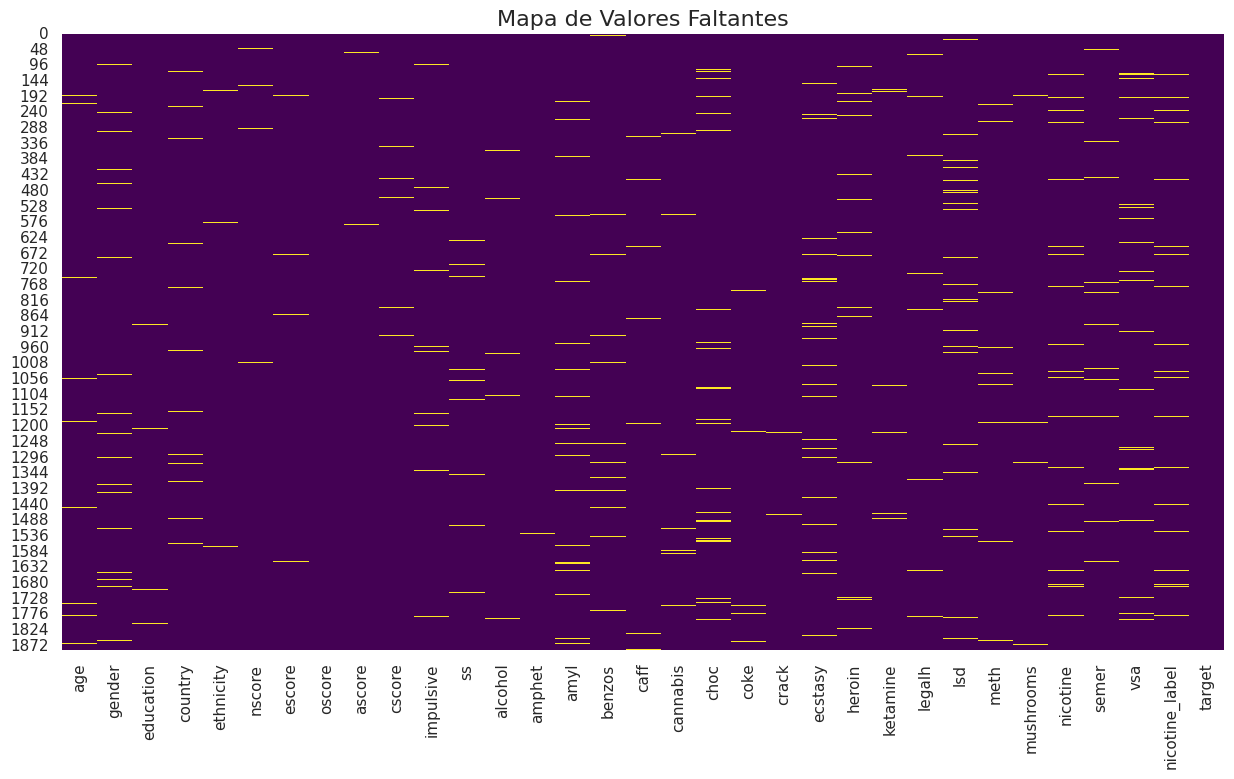

In [6]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Mapa de Valores Faltantes", fontsize=16)
plt.show()

#### Análisis Gráfico

In [7]:
# Divido a las variables en 3 categorias de acuerdo a su naturaleza

cols_demo = ['education','age', 'gender', 'country', 'ethnicity']
cols_psych = [ 'nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impulsive', 'ss']
cols_drugs = [col for col in df.columns if col not in cols_psych + cols_demo + ['nicotine_label', 'target']]

In [8]:
# Mapeo de valores de acuerdo al trabajo asociado en la consigna https://arxiv.org/pdf/1506.06297
edu_map = {
    -2.43591: "Left school <16",
    -1.73790: "Left school at 16",
    -1.22751: "Left school at 17",
    -0.61113: "Left school at 18",
    -0.05921: "Some college (no cert.)",
    0.45468: "Prof. certificate",
    1.16365: "University degree",
    1.98437: "Master’s degree",
    2.59171: "Doctorate"
}

age_map = {
    -0.95197: "18–24",
    -0.07854: "25–34",
    0.49788: "35–44",
    1.09449: "45–54",
    1.82213: "55–64",
    2.59171: "65+"
}

gender_map = {
    0.48246: "Female",
    -0.48246: "Male"
}

country_map = {
    0.96082: "UK",
    0.24923: "USA",
    -0.57009: "Canada",
    -0.28519: "Australia",
    -0.09765: "New Zealand",
    -0.31685: "Other"
}

ethnicity_map = {
    0.12600: "White",
    -0.31685: "Other",
    0.24923: "Mixed-WB",
    -0.28519: "Asian",
    -0.09765: "Black",
    0.96082: "Mixed-WA",
    -0.57009: "Mixed-BA"
}

drug_use_map = {
    0.0: "Never",
    1.0: "> Decade",
    2.0: "Last Decade",
    3.0: "Last Year",
    4.0: "Last Month",
    5.0: "Last Week",
    6.0: "Last Day"
}

order_map = {
    'education': list(edu_map.values()),
    'age': list(age_map.values()),
    'gender': list(gender_map.values()),
    'country': list(country_map.values()),
    'ethnicity': list(ethnicity_map.values()),
    'drug_use': list(drug_use_map.values())
}

In [9]:
def apply_label_maps(df):
    df = df.copy()
    
    df['education'] = df['education'].map(edu_map)
    df['age'] = df['age'].map(age_map)
    df['gender'] = df['gender'].map(gender_map)
    df['country'] = df['country'].map(country_map)
    df['ethnicity'] = df['ethnicity'].map(ethnicity_map)
    

    cols_drugs = [col for col in df.columns if col not in cols_demo + cols_psych + ['nicotine_label', 'target']]
    for col in cols_drugs:
        df[col] = df[col].map(drug_use_map)
    
    return df

df_labeled = apply_label_maps(df)

#### Variables demograficas (cols_demo)

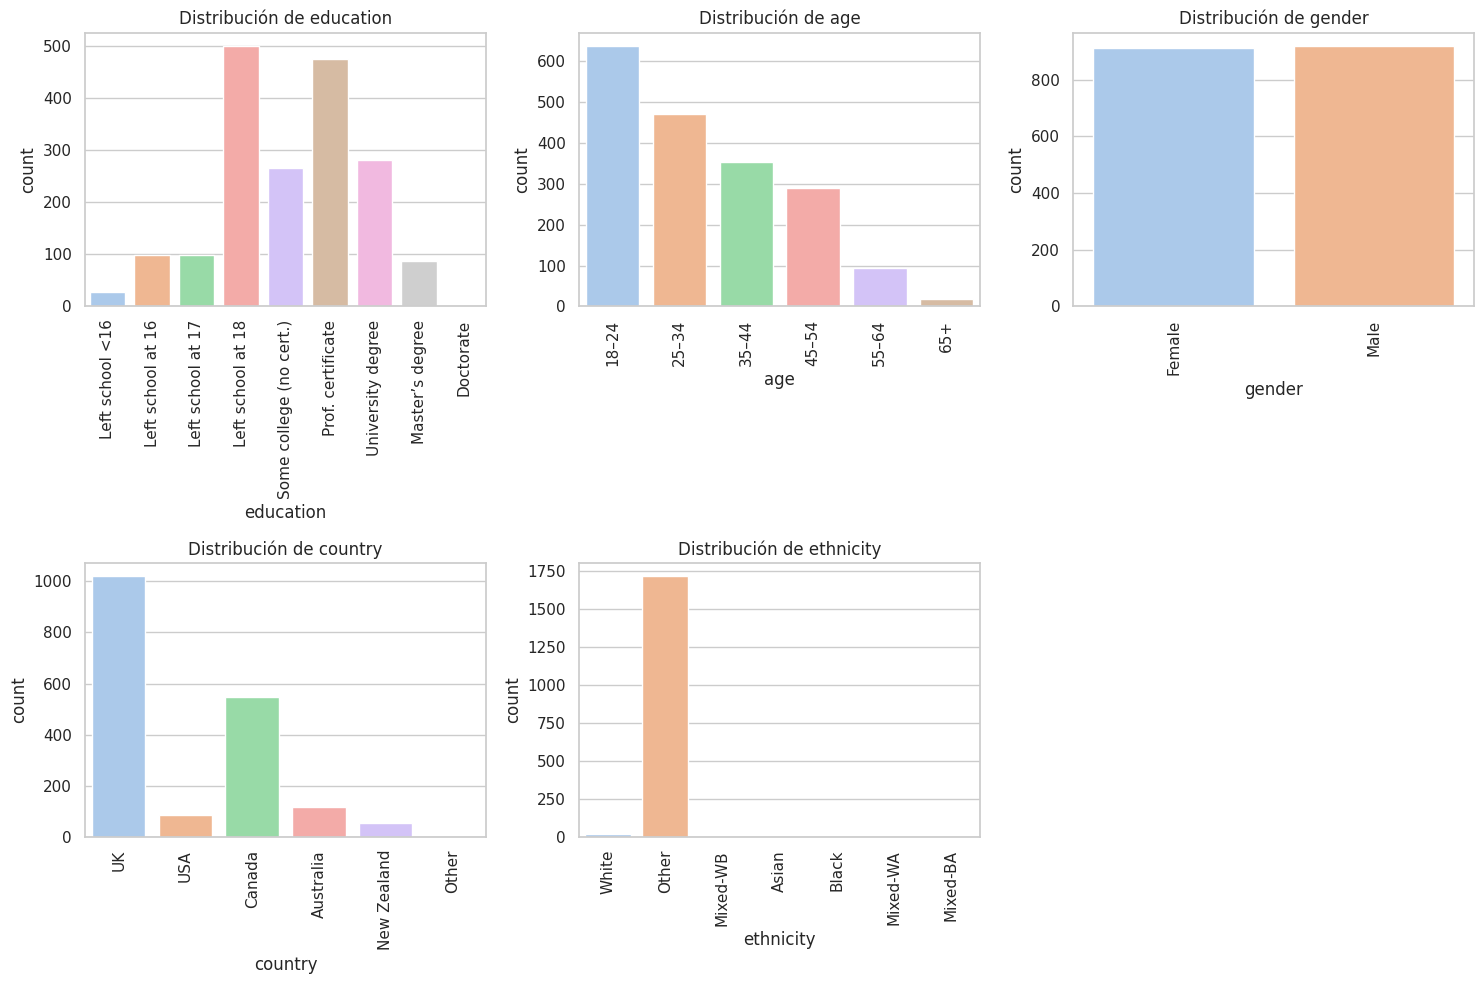

In [10]:
n = len(cols_demo)
rows = math.ceil(n / 3)

plt.figure(figsize=(15, 5 * rows))
for i, var in enumerate(cols_demo, 1): 
    plt.subplot(rows, 3, i)
    sns.countplot(x=df_labeled[var],  order=order_map[var])
    plt.title(f'Distribución de {var}', fontsize=12)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Variables Psicológicas (cols_psych)


* **nscore (Neuroticism):** tendencia a emociones negativas como ansiedad e inestabilidad emocional.
* **escore (Extraversion):** grado de sociabilidad, energía y expresividad.
* **oscore (Openness):** apertura a nuevas ideas, creatividad y curiosidad.
* **ascore (Agreeableness):** compasión, cooperación y amabilidad.
* **cscore (Conscientiousness):** responsabilidad, organización y disciplina.
* **impulsive (Impulsivity):** propensión a actuar sin pensar, incluye impulsividad motora y falta de planificación.
* **ss (Sensation Seeking):** búsqueda de experiencias nuevas y riesgosas, relacionada con conductas exploratorias y de riesgo.

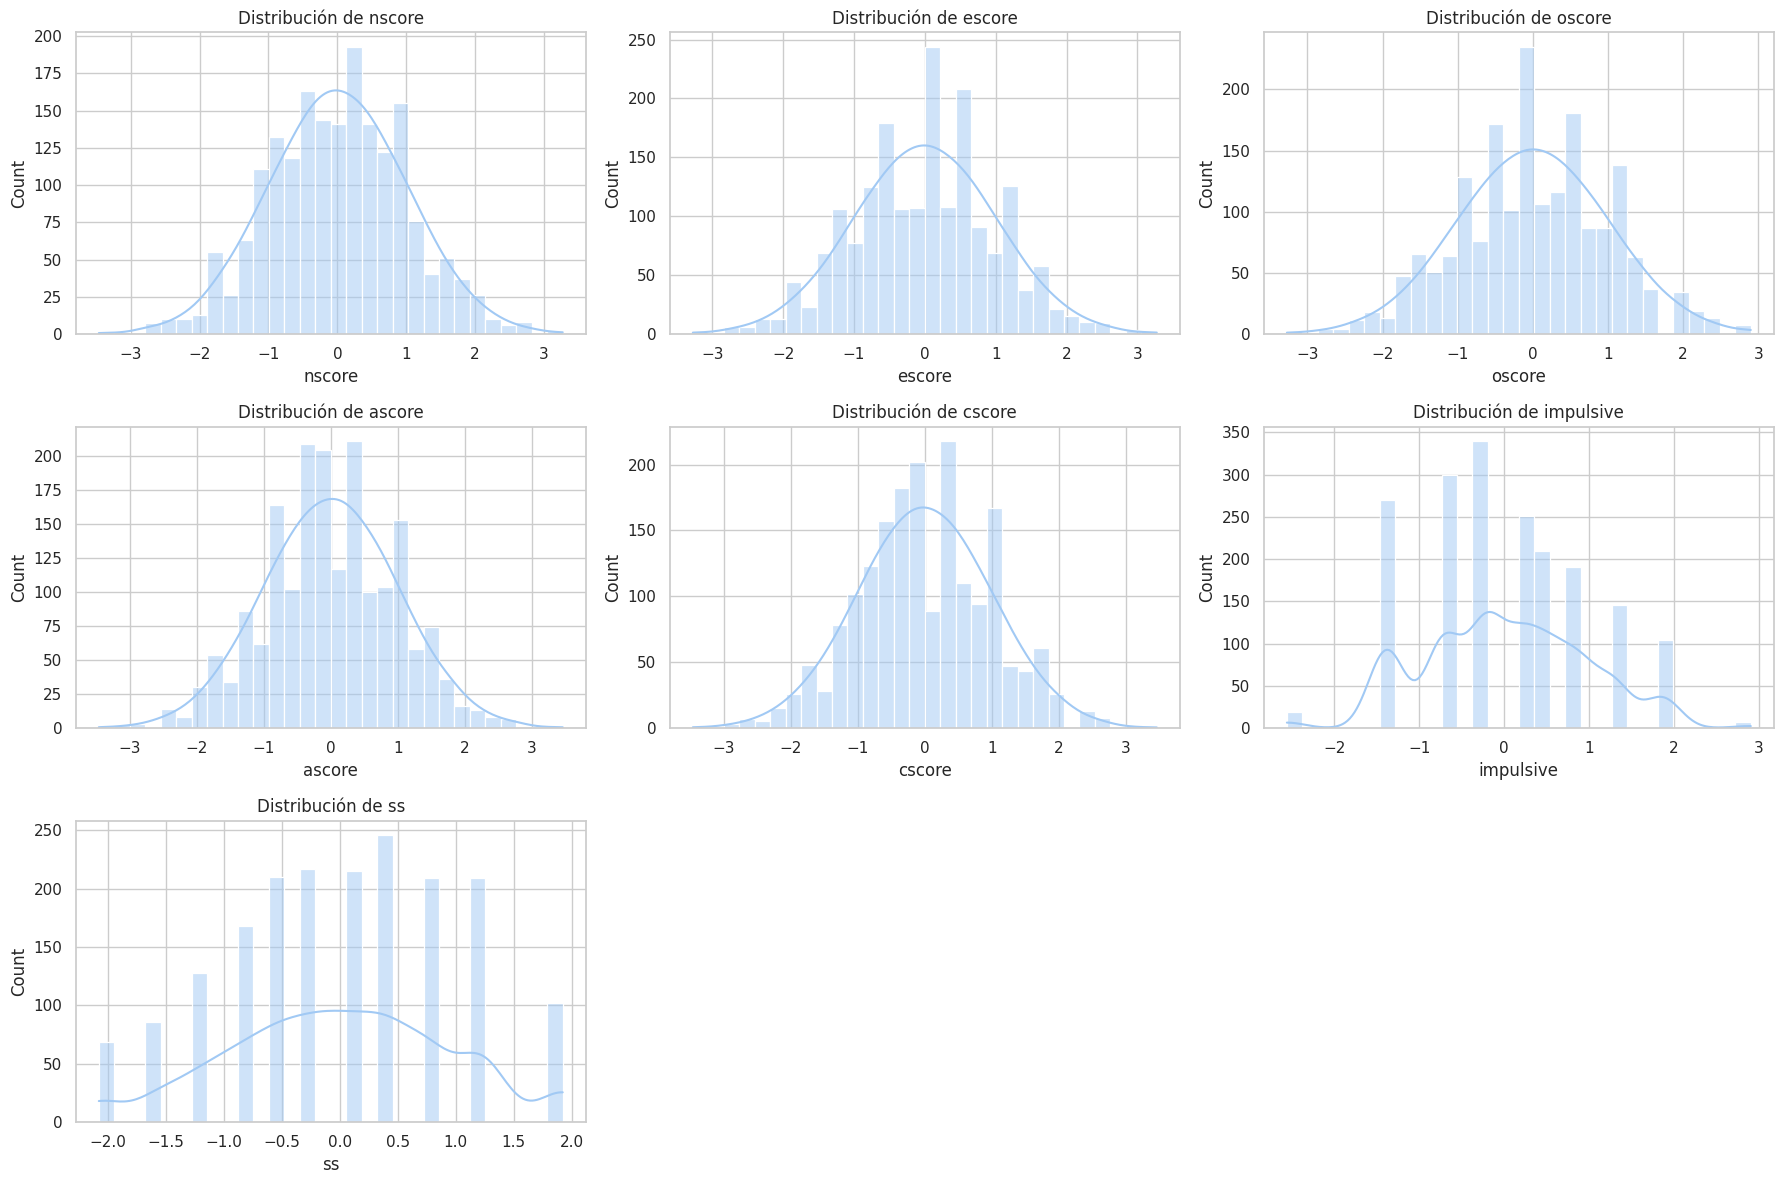

In [11]:
plt.figure(figsize=(18, 12))
for i, var in enumerate(cols_psych, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[var], kde=True, bins=30)
    plt.title(f'Distribución de {var}', fontsize=12)
plt.tight_layout()
plt.show()

#### Variables de uso de drogas (cols_drugs)

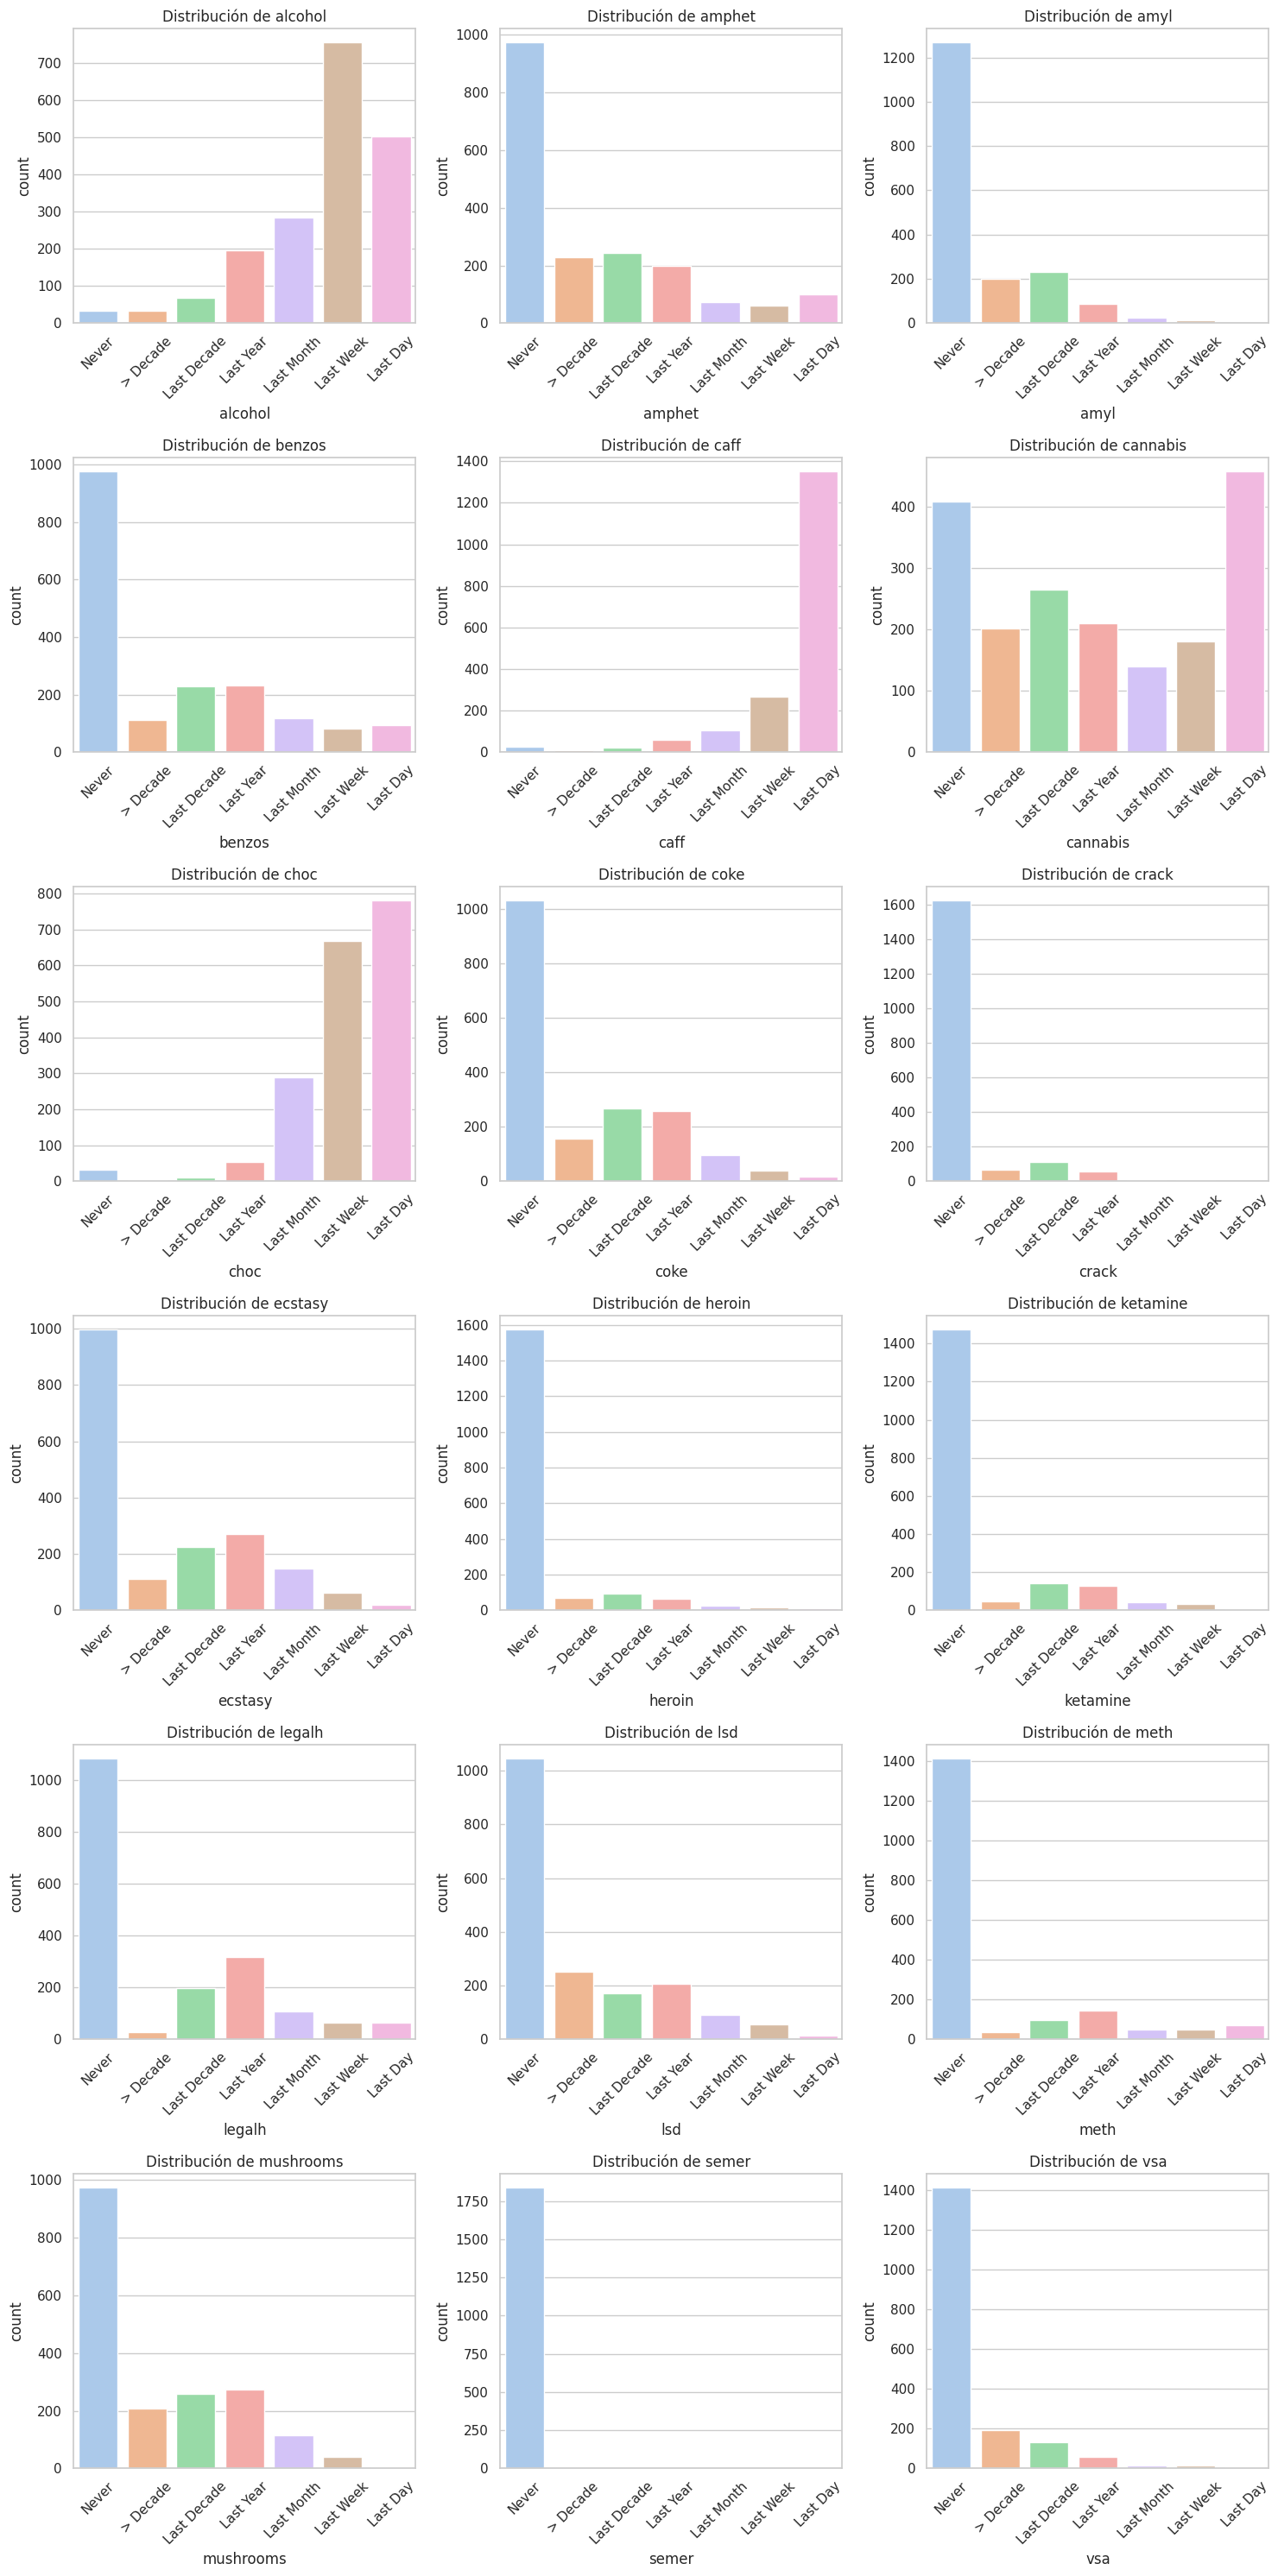

In [12]:
cols_to_plot = [col for col in cols_drugs if col != 'nicotine']

n = len(cols_to_plot)
rows = math.ceil(n / 3)

plt.figure(figsize=(15, 5 * rows))
for i, var in enumerate(cols_to_plot, 1): 
    plt.subplot(rows, 3, i)
    sns.countplot(x=df_labeled[var], order=order_map['drug_use'])
    plt.title(f'Distribución de {var}', fontsize=12)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Variable "target"

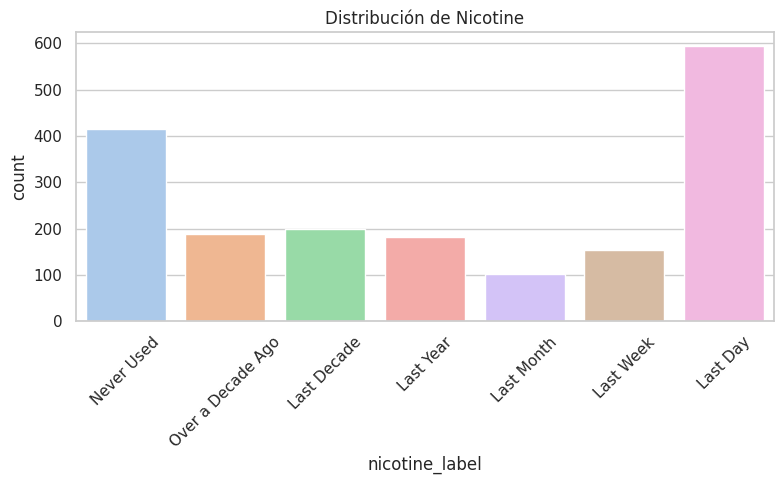

In [13]:
label_order = [
    "Last Day",
    "Last Week",
    "Last Month",
    "Last Year",
    "Last Decade",
    "Over a Decade Ago",
    "Never Used"
]

plt.figure(figsize=(8, 5))
sns.countplot(x="nicotine_label", data=df, order=label_order[::-1])
plt.title("Distribución de Nicotine", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


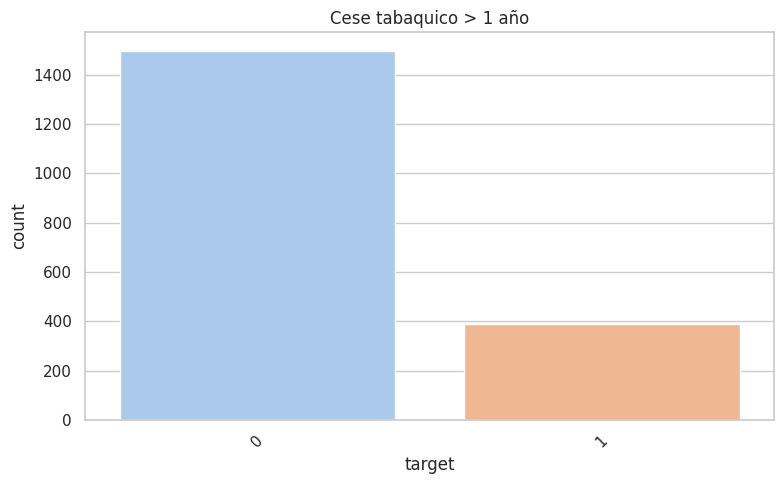

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(x="target", data=df)
plt.title("Cese tabaquico > 1 año", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Análisis de Correlación

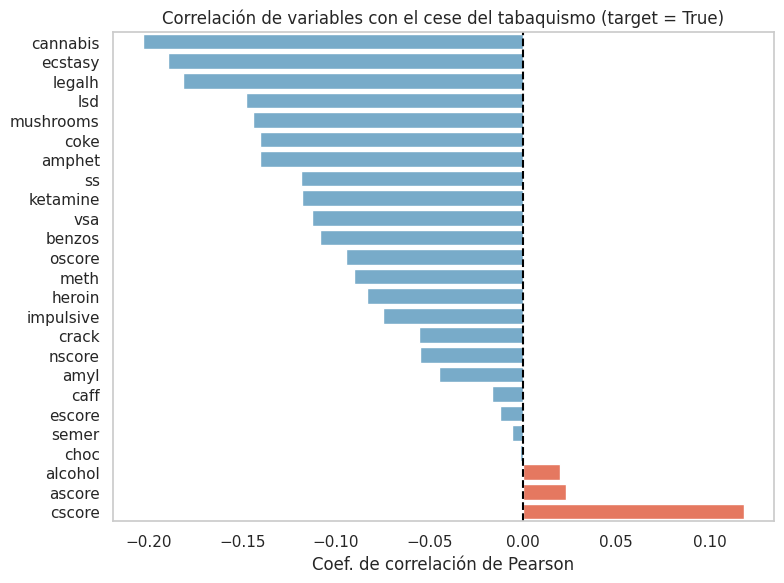

In [15]:
cols_corr = [col for col in df.columns if col not in ['nicotine' , 'nicotine_label'] + cols_demo]
corr_pearson = df[cols_corr].corr(method='pearson')['target'].drop('target').sort_values(ascending=True)

def moderate_colors(val):
     return '#6baed6' if val < 0 else'#fb6a4a'

colors = corr_pearson.apply(moderate_colors)

plt.figure(figsize=(8, 6))
bars = sns.barplot(x=corr_pearson.values, y=corr_pearson.index, palette=colors)

plt.title("Correlación de variables con el cese del tabaquismo (target = True)")
plt.xlabel("Coef. de correlación de Pearson")
plt.axvline(0, color='black', linestyle='--')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

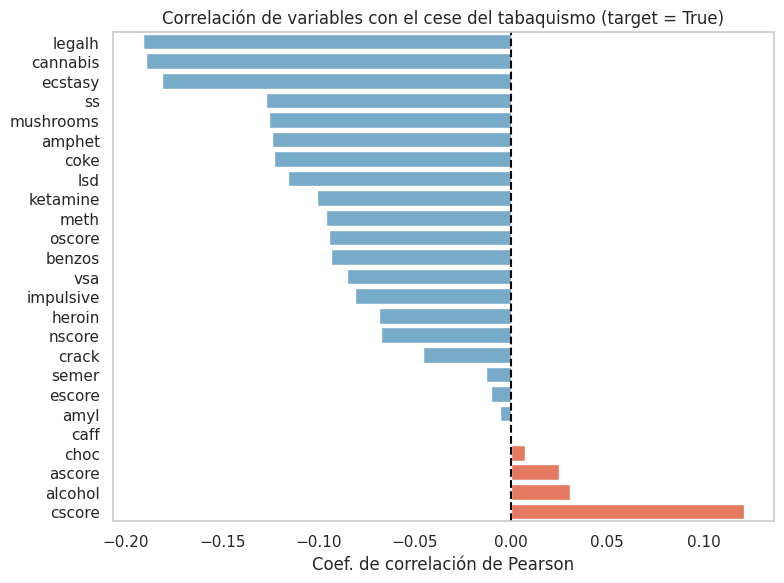

In [16]:
corr_spearman = df[cols_corr].corr(method='spearman')['target'].drop('target').sort_values(ascending=True)

def moderate_colors(val):
     return '#6baed6' if val < 0 else'#fb6a4a'

colors = corr_spearman.apply(moderate_colors)

plt.figure(figsize=(8, 6))
bars = sns.barplot(x=corr_spearman.values, y=corr_spearman.index, palette=colors)

plt.title("Correlación de variables con el cese del tabaquismo (target = True)")
plt.xlabel("Coef. de correlación de Pearson")
plt.axvline(0, color='black', linestyle='--')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### Relacion con Rasgos de la Personalidad

In [17]:
traits = ['nscore', 'escore', 'oscore', 'ascore', 'cscore']
df_clean = df.dropna(subset=traits + ['target'])

results = []

for trait in traits:
    group1 = df_clean[df_clean['target'] == 1][trait]
    group0 = df_clean[df_clean['target'] == 0][trait]

    mean1 = group1.mean()
    std1 = group1.std()
    mean0 = group0.mean()
    std0 = group0.std()

    t_stat, p_val = ttest_ind(group1, group0, equal_var=False)

    results.append({
        "Rasgo": trait.upper(),
        "p-valor": f"{p_val:.4f}"
    })

tabla = pd.DataFrame(results)
print(tabla)

    Rasgo p-valor
0  NSCORE  0.0173
1  ESCORE  0.4749
2  OSCORE  0.0000
3  ASCORE  0.2401
4  CSCORE  0.0000


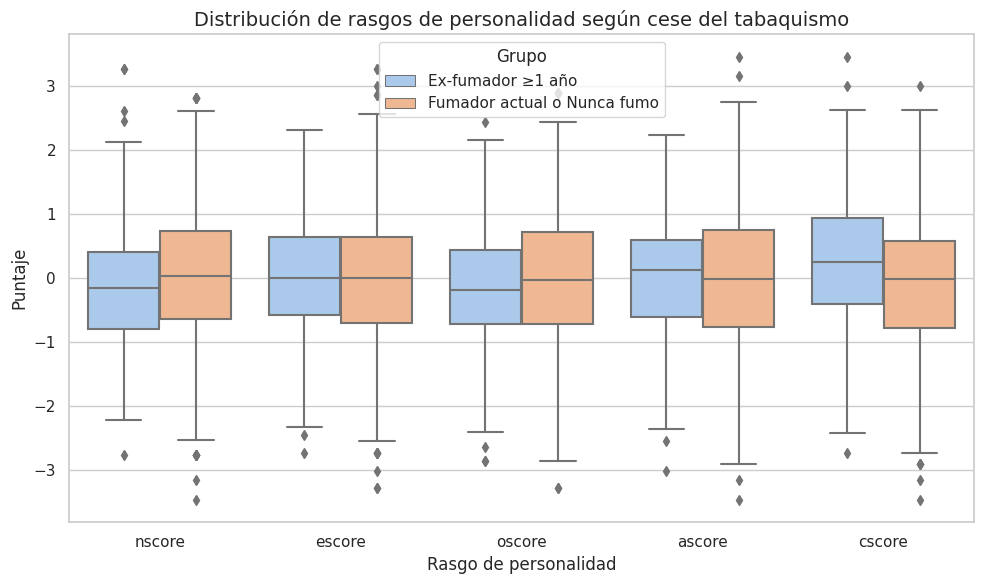

In [18]:
df_long = df.melt(id_vars='target', value_vars=traits, var_name='trait', value_name='score')
df_long['target_label'] = df_long['target'].map({0: 'Fumador actual o Nunca fumo', 1: 'Ex-fumador ≥1 año'})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_long, x='trait', y='score', hue='target_label')

plt.title("Distribución de rasgos de personalidad según cese del tabaquismo", fontsize=14)
plt.xlabel("Rasgo de personalidad")
plt.ylabel("Puntaje")
plt.legend(title="Grupo", loc='best')
plt.tight_layout()  
plt.show()

### Relación con variables demograficas

In [21]:
df_demo_clean = df_labeled[cols_demo + ['target']].dropna()
df_demo_clean

,education,age,gender,country,ethnicity,target
0,Some college (no cert.),35–44,Female,UK,White,1
1,Master’s degree,25–34,Male,UK,Other,0
2,Some college (no cert.),35–44,Male,UK,Other,0
3,University degree,18–24,Female,UK,Other,1
4,Master’s degree,35–44,Female,UK,Other,1
...,...,...,...,...,...,...
1879,Left school at 18,18–24,Male,Australia,Other,0
1880,Left school at 18,18–24,Female,Canada,Other,0
1881,Left school at 18,18–24,Male,Canada,Other,0
1882,Prof. certificate,25–34,Female,Canada,Other,0


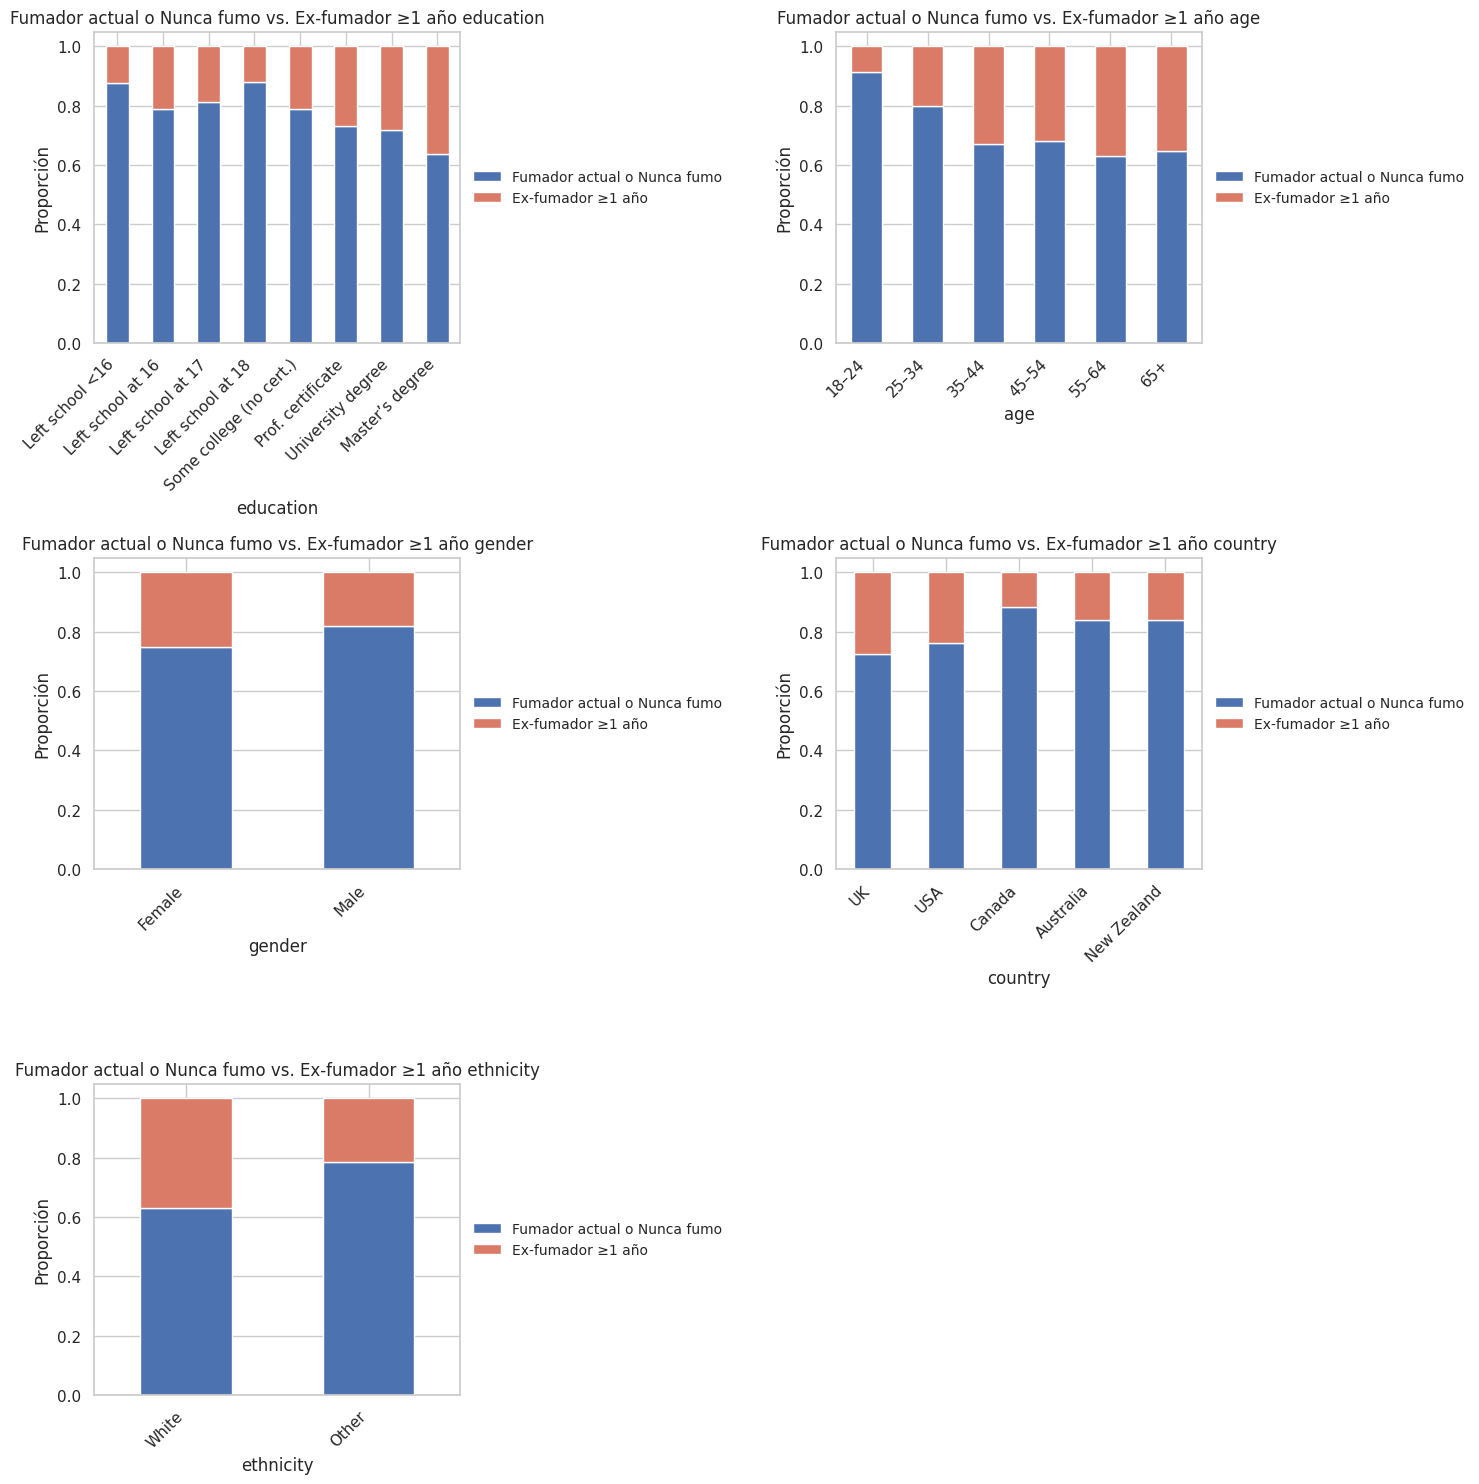

In [25]:
fig, axs = plt.subplots(rows, 2, figsize=(14, 5 * rows))
axs = axs.flatten()
palette = ['#4C72B0', '#D97B66']

df_demo_clean = df_labeled[cols_demo + ['target']].dropna()

for i, var in enumerate(cols_demo):
    ax = axs[i]

    prop_df = (
        df_demo_clean
        .groupby(var)['target']
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
        .rename(columns={0: 'Fumador actual o Nunca fumo', 1: 'Ex-fumador ≥1 año'})
    )

    valid_order = [cat for cat in order_map[var] if cat in prop_df.index]
    prop_df = prop_df.loc[valid_order]

    prop_df.plot(kind='bar', stacked=True, ax=ax, color=palette, legend=False)
    ax.set_title(f'Fumador actual o Nunca fumo vs. Ex-fumador ≥1 año {var}', fontsize=12)
    ax.set_ylabel('Proporción')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0, 1.05)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles,
        labels,
        bbox_to_anchor=(1.02, 0.5),
        loc='center left',
        borderaxespad=0.,
        fontsize=10,
        frameon=False
    )

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [26]:
resultados_chi2 = []
detalle_diferencias = {}

for var in cols_demo:
    tabla = pd.crosstab(df_demo_clean[var], df_demo_clean['target'])

    chi2, p, dof, expected = chi2_contingency(tabla)

    resultados_chi2.append({
        'Variable': var.capitalize(),
        'Chi²': round(chi2, 3),
        'p-valor': round(p, 4),
        'GL': dof
    })

    proporciones = (
        tabla.div(tabla.sum(axis=1), axis=0)
        .rename(columns={0: 'No usuario', 1: 'Usuario'})
    )
    proporciones['Diferencia (Usuario o No usuario - Ex-fumador ≥1 año)'] = (
        proporciones['Usuario'] - proporciones['No usuario']
    )
    
    detalle_diferencias[var] = proporciones

df_resultados_chi2 = pd.DataFrame(resultados_chi2).sort_values('p-valor')
print("Resumen de tests Chi² de independencia entre target y variables demográficas:")
print(df_resultados_chi2)


Resumen de tests Chi² de independencia entre target y variables demográficas:
    Variable     Chi²  p-valor  GL
0  Education   47.288   0.0000   7
1        Age  102.495   0.0000   5
3    Country   49.508   0.0000   4
2     Gender   11.127   0.0009   1
4  Ethnicity    1.802   0.1794   1


### Relación con otras sustancias - Clusterización

#### Clusterización Jerárquica

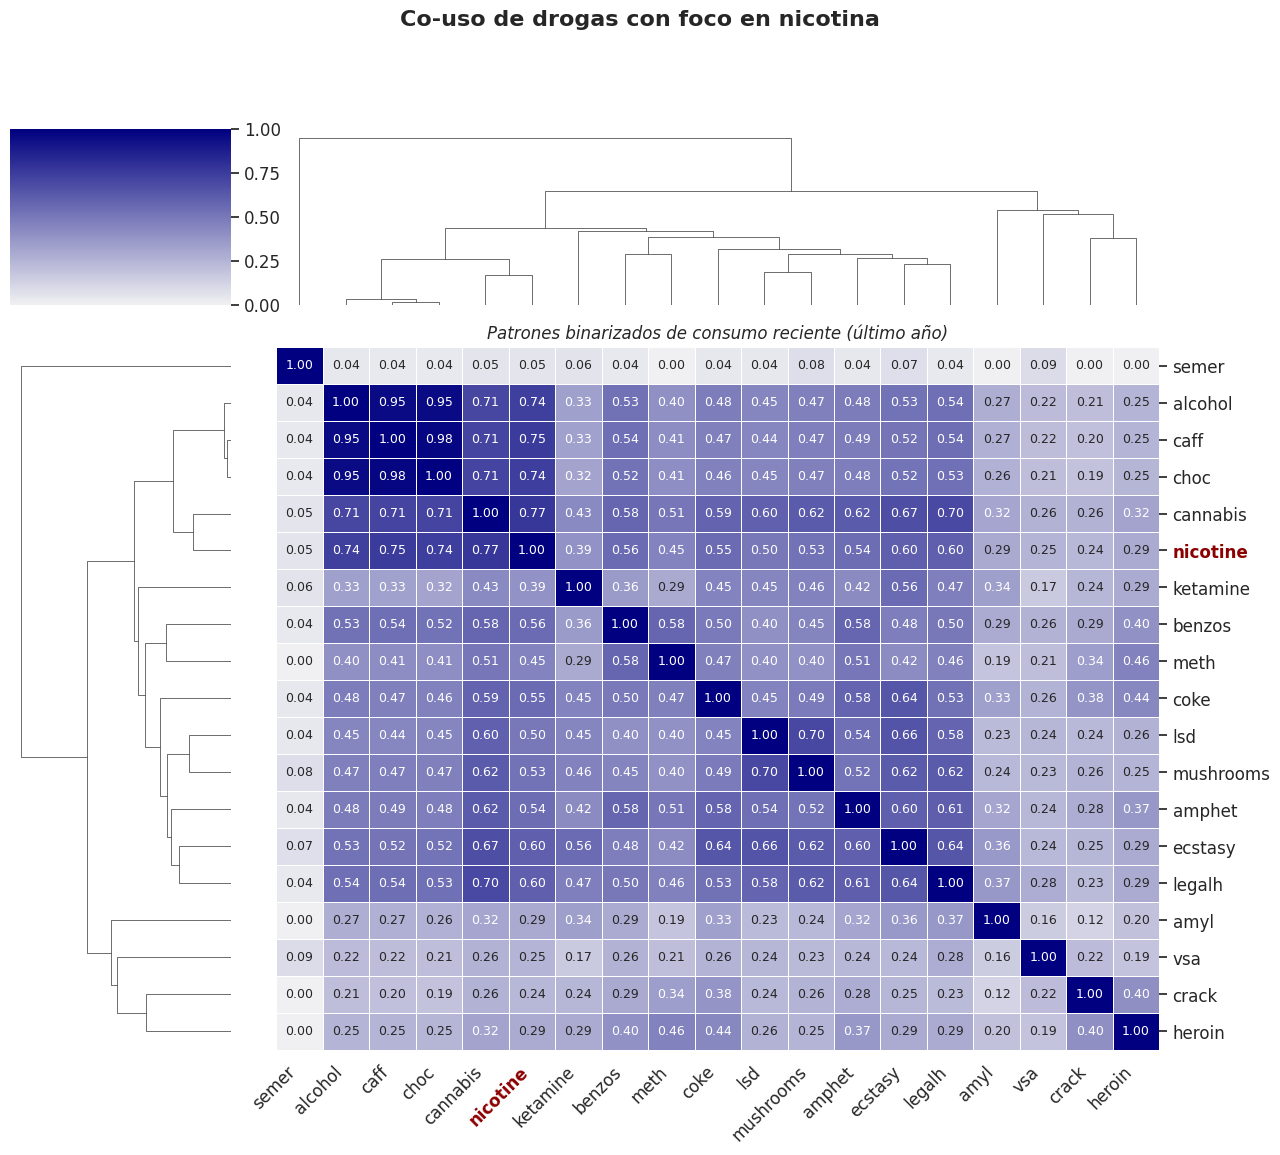

In [27]:
df_bin = df[cols_drugs].dropna().applymap(lambda x: 1 if x >= 3 else 0)

similarity_matrix = cosine_similarity(df_bin.T)
sim_df = pd.DataFrame(similarity_matrix, index=cols_drugs, columns=cols_drugs)

drug_order = sim_df.columns.tolist()
drug_order.remove('nicotine')
drug_order.insert(len(drug_order)//2, 'nicotine')  
sim_df = sim_df.loc[drug_order, drug_order]

sns.set(style="white", font_scale=1.1)
cmap = sns.light_palette("navy", as_cmap=True)
highlight = 'nicotine'

def highlight_labels(ax, highlight_label, axis='x'):
    labels = ax.get_xticklabels() if axis == 'x' else ax.get_yticklabels()
    for label in labels:
        if label.get_text() == highlight_label:
            label.set_weight('bold')
            label.set_color('darkred')

g = sns.clustermap(sim_df,
                   cmap=cmap,
                   linewidths=0.6,
                   linecolor='white',
                   annot=True,
                   fmt=".2f",
                   annot_kws={"size": 9},
                   figsize=(13, 11),
                   xticklabels=True,
                   yticklabels=True)


plt.suptitle("Co-uso de drogas con foco en nicotina", fontsize=16, weight='bold', y=1.05)
g.ax_heatmap.set_title("Patrones binarizados de consumo reciente (último año)", fontsize=12, style='italic')


highlight_labels(g.ax_heatmap, highlight, 'x')
highlight_labels(g.ax_heatmap, highlight, 'y')

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
for spine in g.ax_heatmap.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

#### Clusterización - KNN (distancia coseno) + Grafo

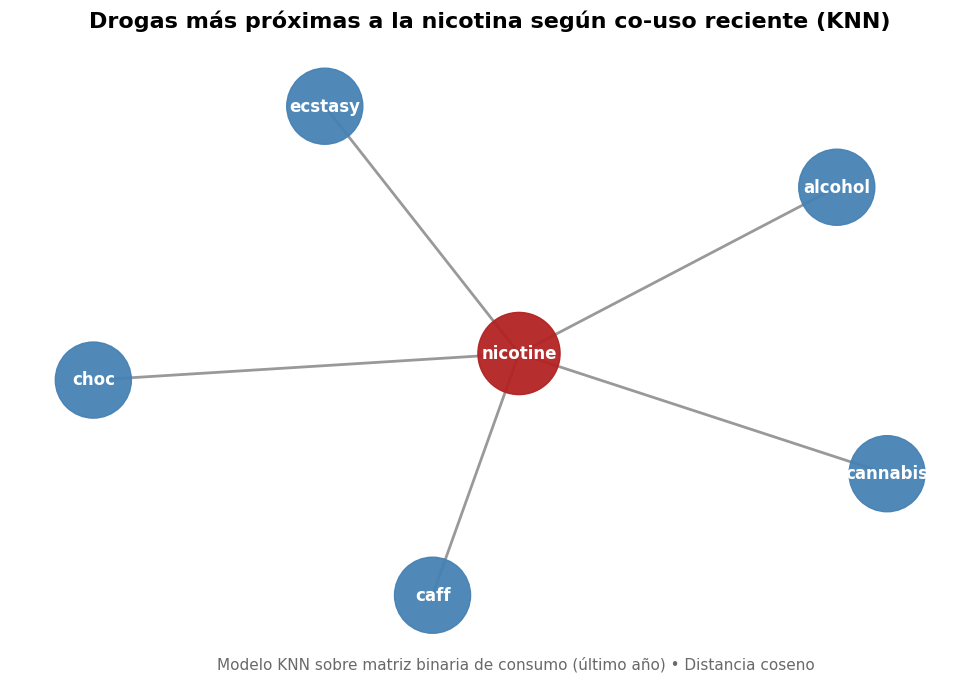

In [28]:
df_bin = df[cols_drugs].dropna().applymap(lambda x: 1 if x >= 3 else 0)
X = df_bin.T

knn = NearestNeighbors(n_neighbors=6, metric='cosine') 
knn.fit(X)

target = 'nicotine'
distances, indices = knn.kneighbors([X.loc[target]])
vecinas = X.index[indices.flatten()]
dist = distances.flatten()

G = nx.Graph()
G.add_node(target)


for droga, d in zip(vecinas[1:], dist[1:]): 
    G.add_node(droga)
    G.add_edge(target, droga, weight=1 - d)


pos = nx.spring_layout(G, k=0.6, seed=42)


node_colors = ['firebrick' if n == target else 'steelblue' for n in G.nodes()]
node_sizes = [3500 if n == target else 3000 for n in G.nodes()]
font_colors = ['white' if n == target else 'white' for n in G.nodes()]
font_weights = ['bold' if n == target else 'normal' for n in G.nodes()]


plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.95)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=2, alpha=0.8)
nx.draw_networkx_labels(G, pos,
                        font_size=12,
                        font_color='white',
                        font_weight='bold',
                        verticalalignment='center')


plt.title("Drogas más próximas a la nicotina según co-uso reciente (KNN)", 
          fontsize=16, weight='bold', color='black', pad=20)

plt.text(0, -1.3, "Modelo KNN sobre matriz binaria de consumo (último año) • Distancia coseno", 
         ha='center', fontsize=11, color='dimgray')

plt.axis('off')
plt.tight_layout()
plt.show()